In [15]:
import os 

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import skfuzzy as fuzz
import skfuzzy.control as ctrl

from PIL import Image

from dataset_generation import *

# Dataset generation and quality checks.

To create dataset 3 parameters are generated:
* Distance - to obstacle, in meters
* Speed - in meters per second (for calculations convenience)
* Friction - implicitly defining state of the road (low for wet, high for dry)

We do not sanity-check the data to explore AI actions in edge cases.

In [16]:
SAVED_DF_PATH = 'data/dataset.csv'
NUM_SAMPLES = 1000

df = None
if os.path.exists(SAVED_DF_PATH):
    df = pd.read_csv(SAVED_DF_PATH)
else:
    df = create_dataset(NUM_SAMPLES, free_road_percentage=0.0)
    df.to_csv(SAVED_DF_PATH, header=True, index=False)

In [17]:
df.sample(10, random_state=42)

,distance_to_obstacle,vehicle_speed,friction
521,133.0,20.365,0.431887
737,44.0,3.751,0.611826
740,25.0,34.481,0.691436
660,134.0,10.072,0.726380
411,137.0,35.658,0.651957
678,50.0,1.660,0.412313
626,59.0,38.619,0.442458
513,142.0,25.413,0.666189
859,64.0,36.033,0.617152
136,13.0,18.281,0.795288


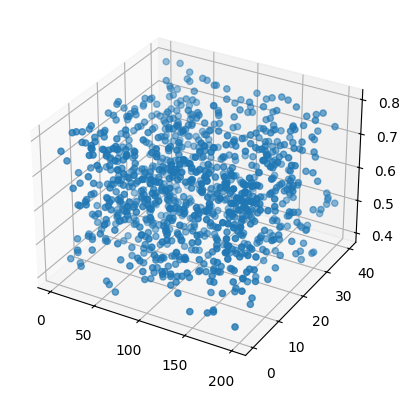

In [18]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(df['distance_to_obstacle'], df['vehicle_speed'], df['friction'], marker='o')
plt.show()

# Fuzzy sets, functions and rules creation
We are going to be using scikit-fuzzy with numpy functions which are suitable to define variables and membership functions. Scikit-fuzzy also allows for simple rule creation and inference, but it lacks to provide a good way to explore the computation step-by-step.

### Defining fuzzy sets for input variables

In [19]:
speed = ctrl.Antecedent(np.arange(MAX_SPEED), 'speed')
distance = ctrl.Antecedent(np.arange(MAX_DISTANCE), 'distance')
road_state = ctrl.Antecedent(np.arange(MIN_FRICTION, MAX_FRICTION + 0.1, 0.1), 'road_state')

### Defining membership functions

In [20]:
SPEED_THRESHOLDS = [
    (0, 5, 15),
    (10, 20, 30),
    (20, 40, 40),
]

DISTANCE_THRESHOLDS = [
    (0, 0, 50),
    (30, 70, 100),
    (70, 200, 200)
]

In [21]:
distance['small'] = fuzz.trimf(distance.universe, DISTANCE_THRESHOLDS[0])
distance['medium'] = fuzz.trimf(distance.universe, DISTANCE_THRESHOLDS[1])
distance['large'] = fuzz.trimf(distance.universe, DISTANCE_THRESHOLDS[2])

speed['low'] = fuzz.trimf(speed.universe, SPEED_THRESHOLDS[0])
speed['medium'] = fuzz.trimf(speed.universe, SPEED_THRESHOLDS[1])
speed['high'] = fuzz.trimf(speed.universe, SPEED_THRESHOLDS[2])

road_state['wet'] = fuzz.trapmf(road_state.universe, [0.4, 0.4, 0.5, 0.6])
road_state['dry'] = fuzz.trapmf(road_state.universe, [0.5, 0.7, 0.8, 0.8])

C:\Users\volodymyr\.virtualenvs\computational_intelligence-ab0f9zpH\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


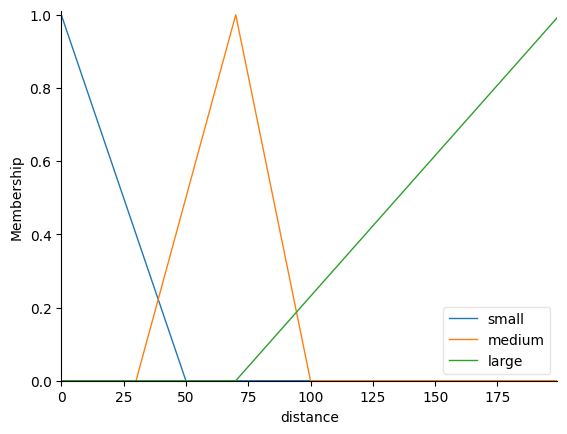

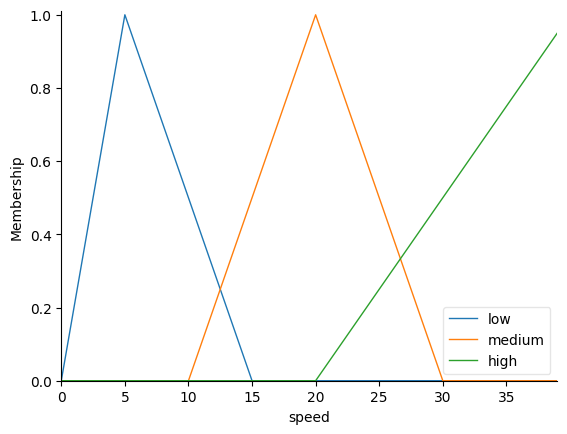

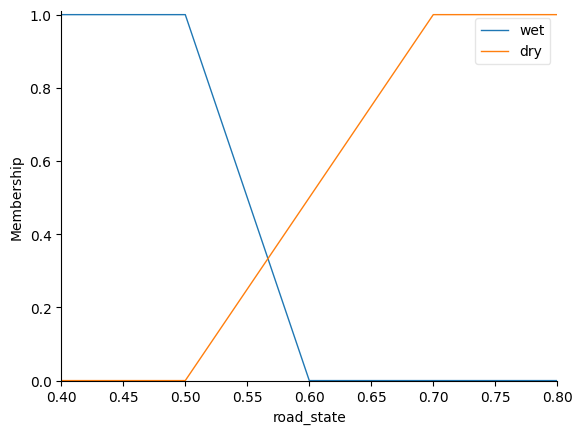

In [22]:
for variable in (distance, speed, road_state):
    variable.view()

### Define target variable

We define target variable as continious one, so the crisp value is the highest scoring membership.

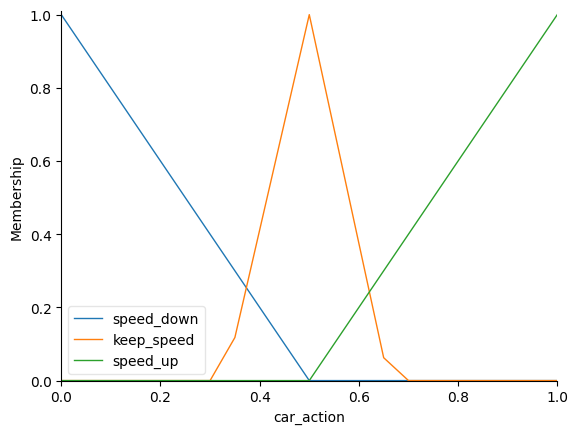

In [23]:
car_action = ctrl.Consequent(np.arange(0, 1 + 0.05, 0.05), 'car_action', 'som')

car_action['speed_down'] = fuzz.trimf(car_action.universe, [0, 0, 0.5])
car_action['keep_speed'] = fuzz.trimf(car_action.universe, [0.33, 0.5, 0.66])
car_action['speed_up'] = fuzz.trimf(car_action.universe, [0.5, 1, 1])

car_action.view()

### Defining rules

A set of rules defined like this:

distance[small] AND speed[high] => [car_action[speed_down]]  
distance[small] AND speed[medium] => [car_action[speed_down]]  
distance[small] AND speed[low] => [car_action[speed_down]]  
distance[medium] AND speed[high] => [car_action[speed_down]]  
distance[medium] AND speed[medium] => [car_action[keep_speed]]  
distance[medium] AND speed[low] => [car_action[speed_up]]  
distance[large] AND speed[high] => [car_action[keep_speed]]  
distance[large] AND speed[medium] => [car_action[speed_up]]  
distance[large] AND speed[low] => [car_action[speed_up]]  
road_state[wet] AND distance[small] => [car_action[speed_down]]  
road_state[wet] AND speed[high] => [car_action[speed_down]]  
(road_state[dry] AND distance[medium]) AND speed[medium] => [car_action[keep_speed]]  
(road_state[dry] AND distance[large]) AND speed[high] => [car_action[keep_speed]]  
road_state[dry] AND speed[low] => [car_action[keep_speed]]  
road_state[wet] AND speed[medium] => [car_action[keep_speed]]  

In [24]:
# Rules defined by access to computed value stored in a context

rules = [
    lambda ctx: np.fmin(np.fmin(ctx['distance']['small'], ctx['speed']['high']), car_action['speed_down'].mf),
    lambda ctx: np.fmin(np.fmin(ctx['distance']['small'], ctx['speed']['medium']), car_action['speed_down'].mf),
    lambda ctx: np.fmin(np.fmin(ctx['distance']['small'], ctx['speed']['low']), car_action['speed_down'].mf),
                                                                                                     
    lambda ctx: np.fmin(np.fmin(ctx['distance']['medium'], ctx['speed']['high']), car_action['speed_down'].mf),
    lambda ctx: np.fmin(np.fmin(ctx['distance']['medium'], ctx['speed']['medium']), car_action['keep_speed'].mf),
    lambda ctx: np.fmin(np.fmin(ctx['distance']['medium'], ctx['speed']['low']), car_action['speed_up'].mf) ,
                                                                                                     
    lambda ctx: np.fmin(np.fmin(ctx['distance']['large'], ctx['speed']['high']), car_action['keep_speed'].mf),
    lambda ctx: np.fmin(np.fmin(ctx['distance']['large'], ctx['speed']['medium']), car_action['speed_up'].mf),
    lambda ctx: np.fmin(np.fmin(ctx['distance']['large'], ctx['speed']['low']), car_action['speed_up'].mf),
                                                                                                     
    lambda ctx: np.fmin(np.fmin(ctx['road_state']['wet'], ctx['distance']['small']), car_action['speed_down'].mf),
    lambda ctx: np.fmin(np.fmin(ctx['road_state']['wet'], ctx['speed']['high']), car_action['speed_down'].mf),
                                                                                                    
    lambda ctx: np.fmin(np.fmin(ctx['road_state']['dry'], np.fmin(ctx['distance']['medium'], ctx['speed']['medium'])), car_action['keep_speed'].mf),
    lambda ctx: np.fmin(np.fmin(ctx['road_state']['dry'], np.fmin(ctx['distance']['large'], ctx['speed']['high'])), car_action['keep_speed'].mf),
    lambda ctx: np.fmin(np.fmin(ctx['road_state']['dry'], ctx['speed']['low']), car_action['keep_speed'].mf),
                                                                                                    
    lambda ctx: np.fmin(np.fmin(ctx['road_state']['wet'], ctx['speed']['medium']), car_action['keep_speed'].mf)                        
]

In [25]:
def redraw_figure(figure, target_ax):
    figure.canvas.draw()
    rgba_bytes      = figure.canvas.buffer_rgba().tobytes()
    width, height   = figure.canvas.get_width_height()

    pil_image = Image.frombytes(
        mode="RGBA",
        size=[width, height],
        data=rgba_bytes,
    )
    image_array = np.array(pil_image)

    plt.close()

    target_ax.axis('off')
    target_ax.imshow(image_array)

def plot_rule(activation, target_ax):
    fig, ax = ctrl.visualization.FuzzyVariableVisualizer(car_action).view()
    ax.fill_between(
        car_action.universe, 
        np.zeros_like(car_action.universe), 
        activation, 
        facecolor='b', 
        alpha=0.7
    )

    redraw_figure(fig, target_ax)

def plot_result(activation, centroid_x, centroid, target_ax):
    fig, ax = ctrl.visualization.FuzzyVariableVisualizer(car_action).view()
    ax.fill_between(
        car_action.universe, 
        np.zeros_like(car_action.universe), 
        activation, 
        facecolor='b', 
        alpha=0.7
    )

    ax.plot([centroid_x, centroid_x], [0, centroid], 'k', linewidth=1.5, alpha=0.9)
    redraw_figure(fig, target_ax)

### Mamdani inference

Here Mamdani fuzzy inference is implemented:
* Get the membership values of antecedents
* Use `max` and `min` as | and & to get the activation function
* Use `min` as implication between activation and consequent membership function
* Aggregate consequent activation with `max` 
* Find the centroid of the figure under the function curve - that is crisp output

In [26]:
def select_action(speed_in, distance_in, road_state_in, debug=False):
    
    def interpret(variable, raw_input):
        interpretations = {}
        for term in variable.terms:
            interpretations[term] = fuzz.interp_membership(variable.universe, variable[term].mf, raw_input)

        return interpretations

    speed_interpretations = interpret(speed, speed_in)
    distance_interpretations = interpret(distance, distance_in)
    road_state_interpretations = interpret(road_state, road_state_in)

    context = {
        'speed': speed_interpretations,
        'distance': distance_interpretations,
        'road_state': road_state_interpretations
    }

    if debug:
        fig = plt.figure(figsize=(15, 8))
        gs_main = gridspec.GridSpec(1, 2, figure=fig)
        gs_activations = gridspec.GridSpecFromSubplotSpec(4, 4,subplot_spec=gs_main[0])

    acc = None
    for idx, rule in enumerate(rules):
        activation = rule(context)
        
        if debug:
            ax = fig.add_subplot(gs_activations[idx // 4, idx % 4])
            plot_rule(activation, ax)
        
        if acc is None:
            acc = activation
            continue

        acc = np.fmax(acc, activation)
    
    try:
        activation_x = fuzz.defuzz(car_action.universe, acc, 'centroid')
    except:
        activation_x = 0.0

    if debug:
        activation = fuzz.interp_membership(car_action.universe, acc, activation_x)
        ax = fig.add_subplot(gs_main[1])
        plot_result(acc, activation_x, activation, ax)
        plt.show()

        print(context)

    interpretation = interpret(car_action, activation_x)
    selected_action = max(interpretation.items(), key = lambda kv: kv[1])[0]

    return activation_x, interpretation, selected_action

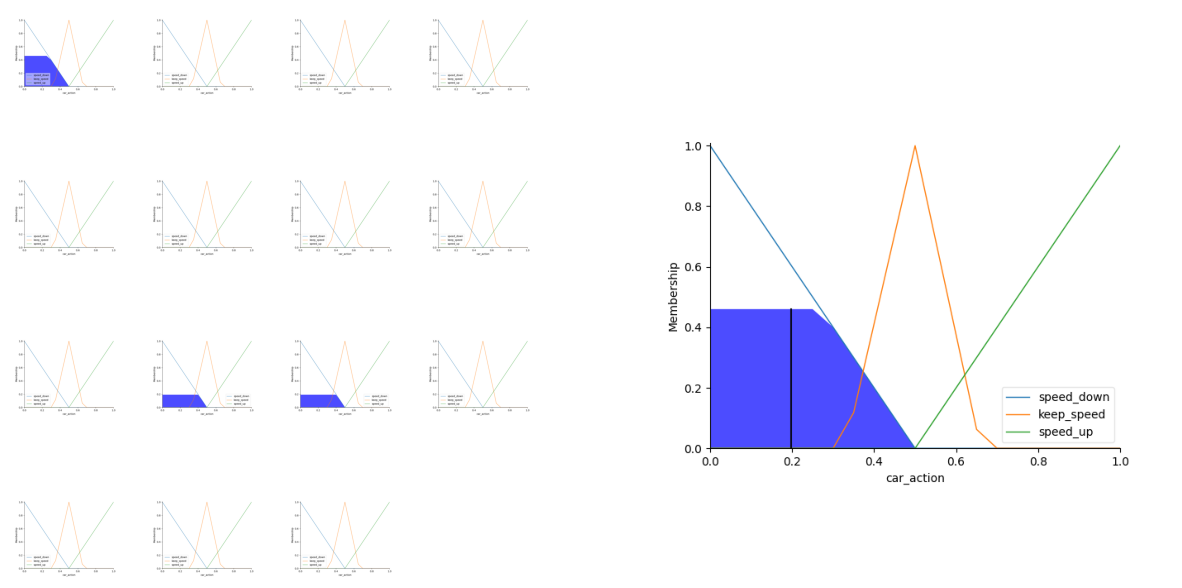

{'speed': {'low': 0.0, 'medium': 0.0, 'high': 0.8594}, 'distance': {'small': 0.46, 'medium': 0.0, 'large': 0.0}, 'road_state': {'wet': 0.19189460266001113, 'dry': 0.40405269866999444}}
[27.         37.188       0.58081054] => speed_down


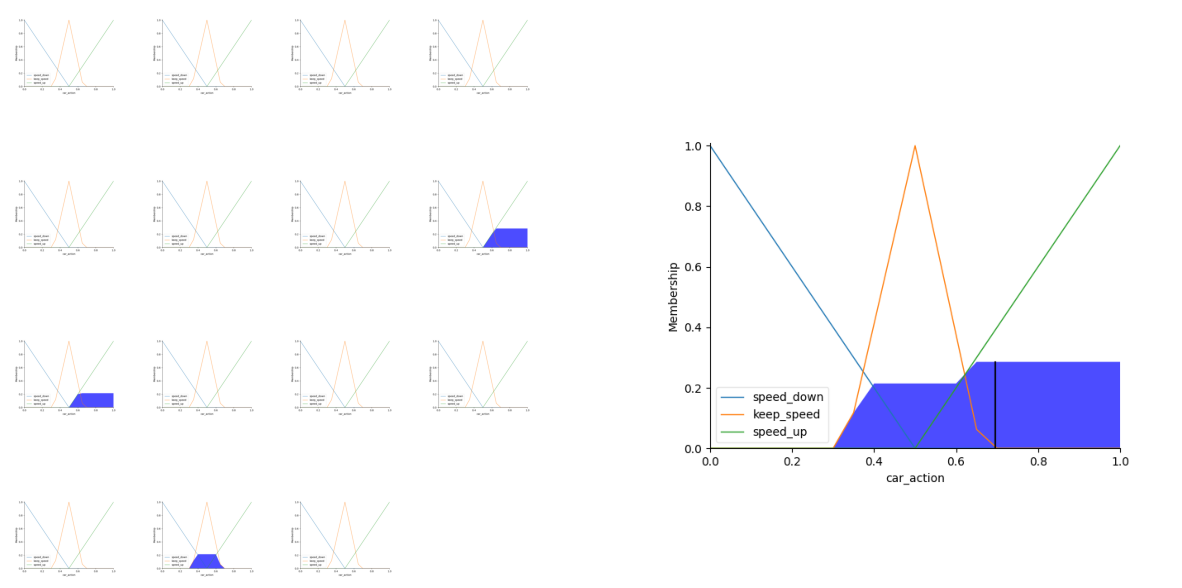

{'speed': {'low': 0.21430000000000007, 'medium': 0.28569999999999995, 'high': 0.0}, 'distance': {'small': 0.0, 'medium': 0.0, 'large': 0.3230769230769231}, 'road_state': {'wet': 0.0, 'dry': 1.0}}
[112.         12.857       0.7179086] => speed_up


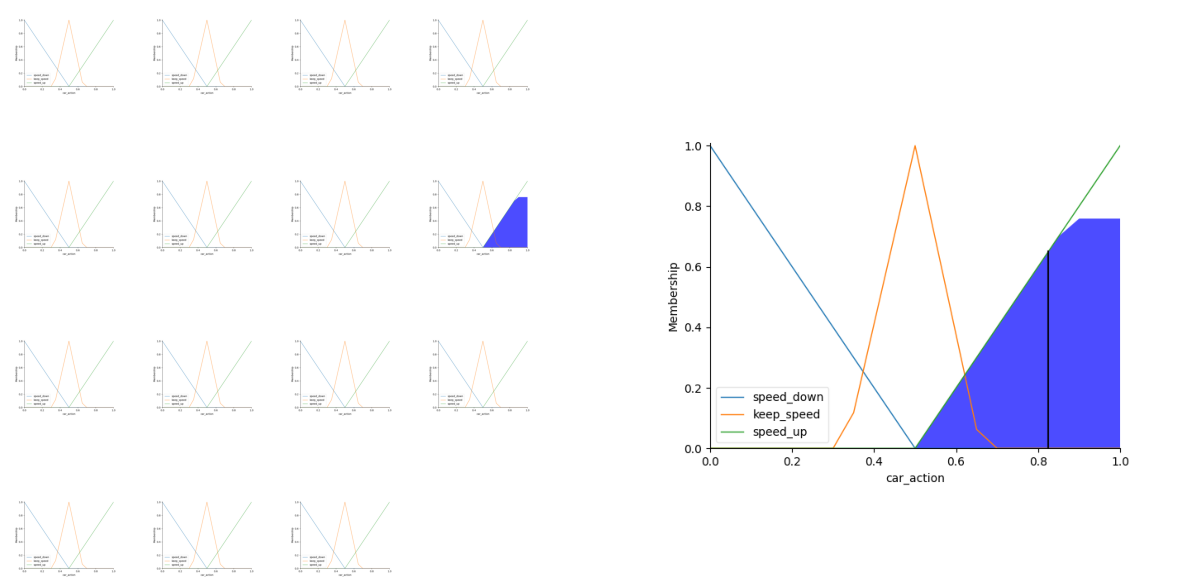

{'speed': {'low': 0.0, 'medium': 0.759, 'high': 0.0}, 'distance': {'small': 0.0, 'medium': 0.0, 'large': 0.9230769230769231}, 'road_state': {'wet': 0.0, 'dry': 1.0}}
[190.          17.59         0.76101926] => speed_up


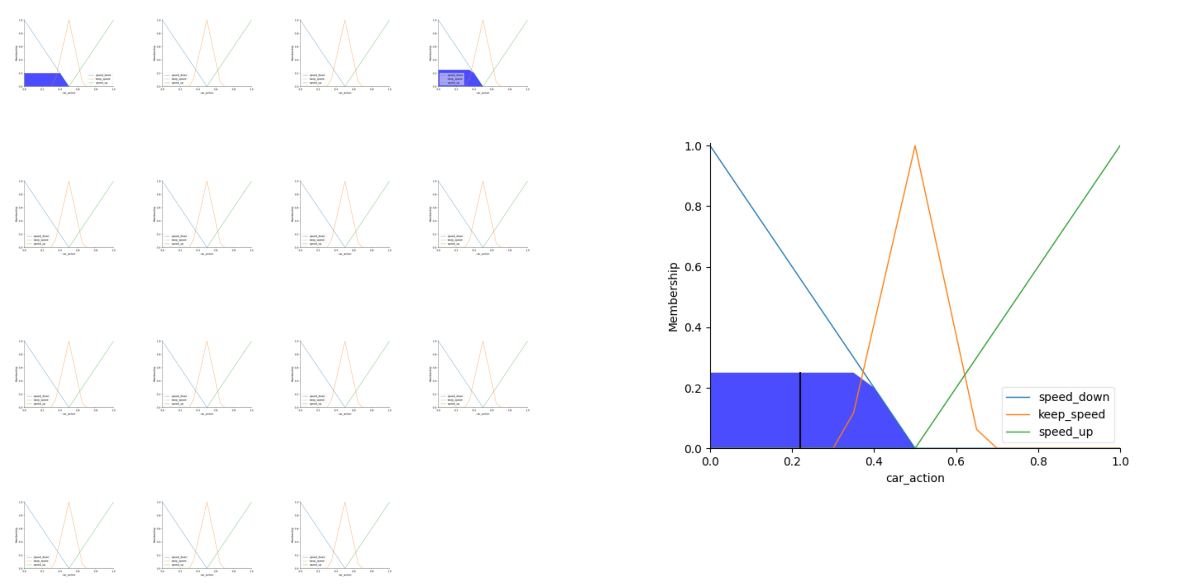

{'speed': {'low': 0.0, 'medium': 0.0, 'high': 0.5164500000000001}, 'distance': {'small': 0.2, 'medium': 0.25, 'large': 0.0}, 'road_state': {'wet': 0.0, 'dry': 0.9973291785200985}}
[40.         30.329       0.69946584] => speed_down


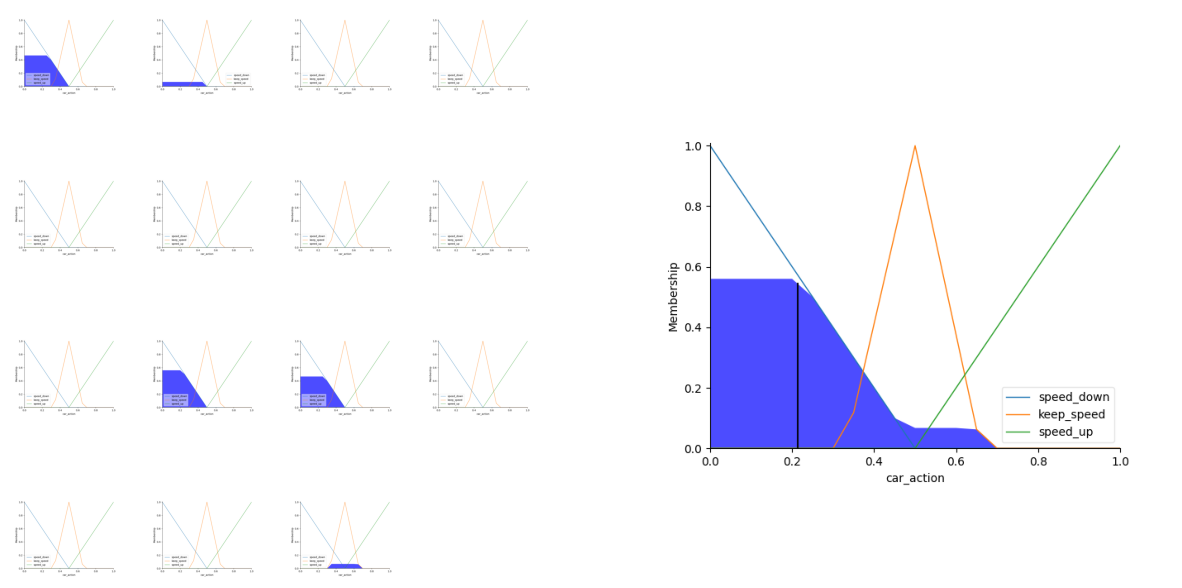

{'speed': {'low': 0.0, 'medium': 0.06729999999999983, 'high': 0.4663500000000001}, 'distance': {'small': 0.56, 'medium': 0.0, 'large': 0.0}, 'road_state': {'wet': 1.0, 'dry': 0.0}}
[22.         29.327       0.42801817] => speed_down


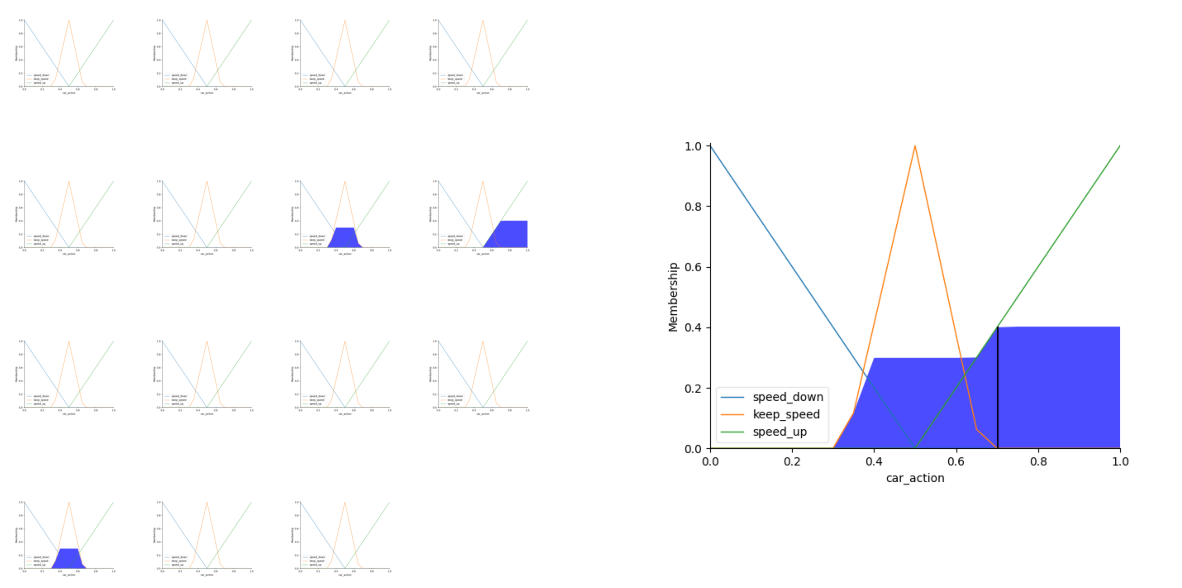

{'speed': {'low': 0.0, 'medium': 0.4021000000000001, 'high': 0.29894999999999994}, 'distance': {'small': 0.0, 'medium': 0.0, 'large': 0.8769230769230769}, 'road_state': {'wet': 0.0, 'dry': 0.7828897833653872}}
[184.          25.979        0.65657796] => speed_up


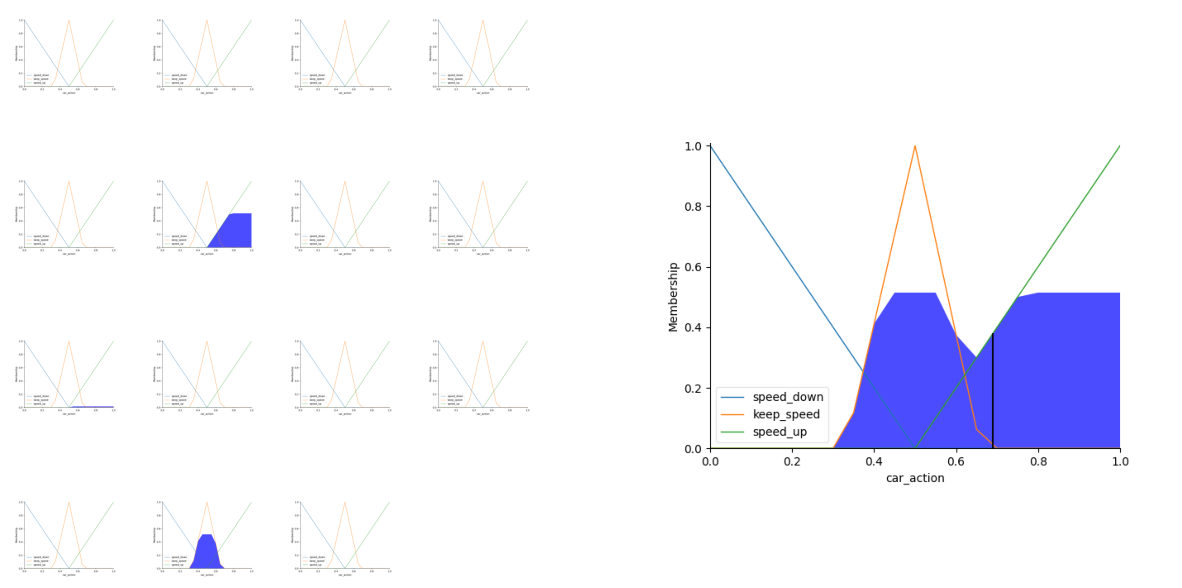

{'speed': {'low': 0.5145, 'medium': 0.0, 'high': 0.0}, 'distance': {'small': 0.0, 'medium': 0.9333333333333333, 'large': 0.015384615384615385}, 'road_state': {'wet': 0.0, 'dry': 0.5791436011501484}}
[72.          9.855       0.61582872] => speed_up


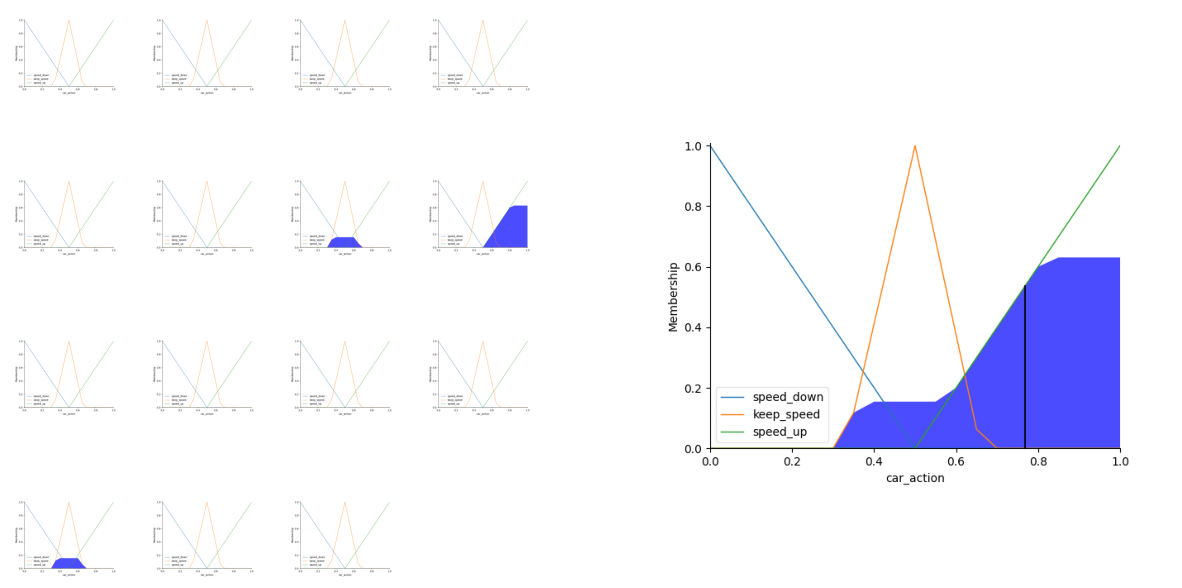

{'speed': {'low': 0.0, 'medium': 0.6914999999999999, 'high': 0.15425000000000003}, 'distance': {'small': 0.0, 'medium': 0.0, 'large': 0.6307692307692307}, 'road_state': {'wet': 0.0, 'dry': 1.0}}
[152.          23.085        0.73935895] => speed_up


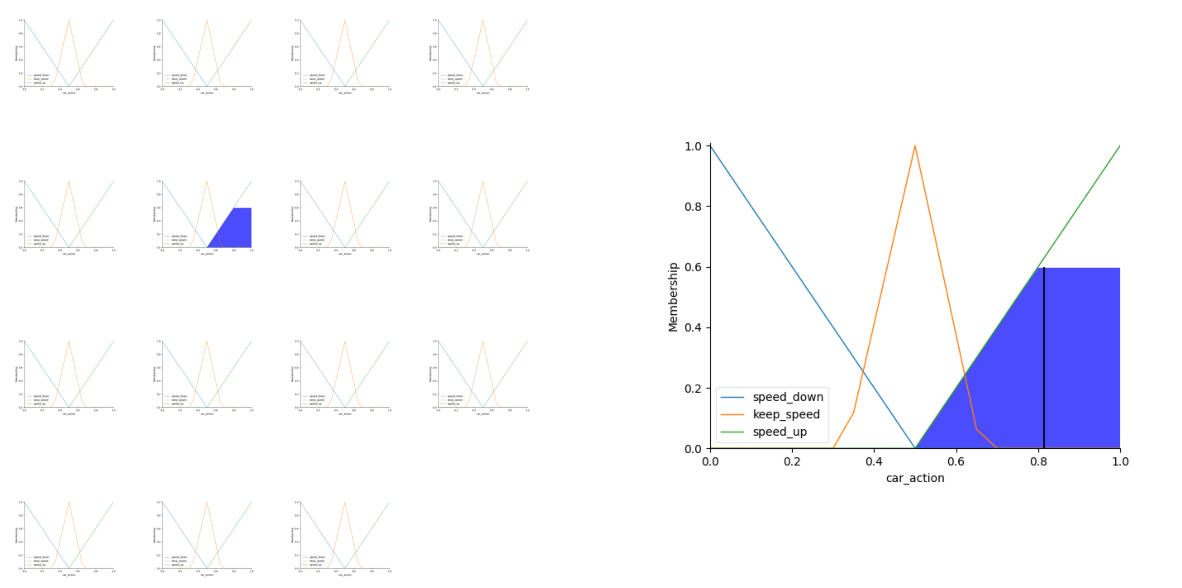

{'speed': {'low': 0.5967, 'medium': 0.0, 'high': 0.0}, 'distance': {'small': 0.0, 'medium': 0.65, 'large': 0.0}, 'road_state': {'wet': 1.0, 'dry': 0.0}}
[56.          9.033       0.46539336] => speed_up


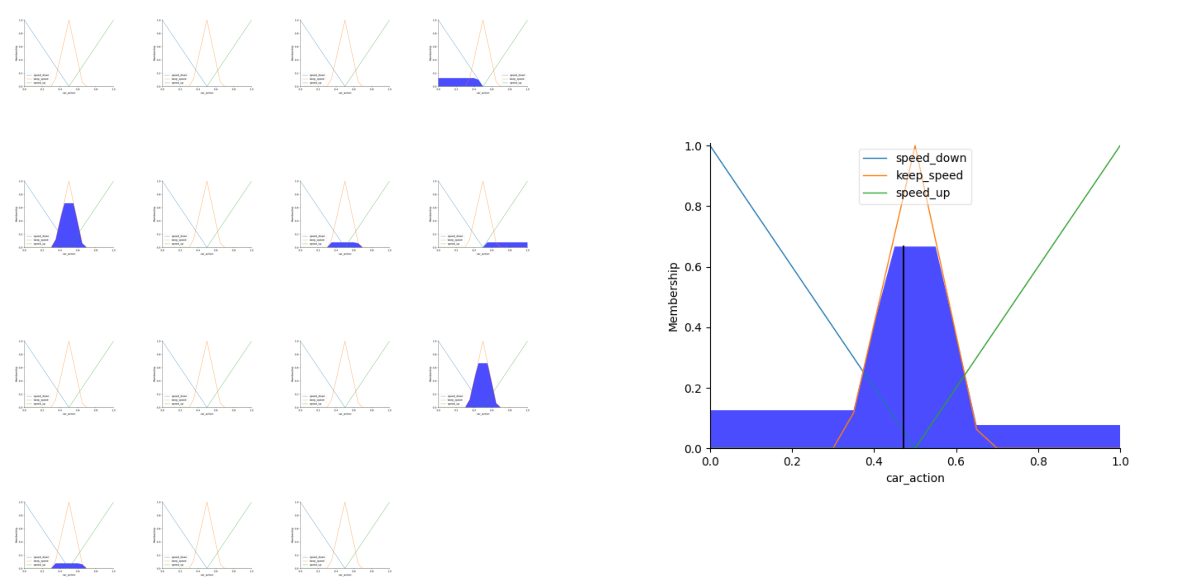

{'speed': {'low': 0.0, 'medium': 0.7483000000000001, 'high': 0.12584999999999996}, 'distance': {'small': 0.0, 'medium': 0.6666666666666666, 'large': 0.07692307692307693}, 'road_state': {'wet': 0.0, 'dry': 1.0}}
[80.        22.517      0.7985233] => keep_speed


In [27]:
samples = df.sample(10, random_state=123)

for sample in samples.to_numpy():
    _, _, action = select_action(
        speed_in=sample[1], 
        distance_in=sample[0], 
        road_state_in=sample[2], 
        debug=True
    )
    print(f"{sample} => {action}")

# Continious control

Our dataset can be interpreted as an input to a problem of stopping the car on some target spot (here an obstacle). Following code can run a simulation of car movement controlled by our fuzzy system.

In [28]:
def simulate_movement(speed_in, distance_in, road_state_in, polling_rate, verbose=False):
    current_speed = speed_in
    current_distance = distance_in
    friction = road_state_in

    g = 9.81
    acceleration = 5

    history = []
    delta = 1 / polling_rate
    timestamp = 0.0

    while current_distance > 1e-6 and current_speed > 1e-6:
        _, _, action = select_action(speed_in=current_speed, distance_in=current_distance, road_state_in=friction)

        history_entry = (timestamp, current_speed, current_distance, action)
        history.append(history_entry)

        if verbose:
            print(f"{timestamp}: {(current_speed, current_distance)} => {action}")

        if action == "speed up":
            current_speed = current_speed + acceleration * delta
        elif action == "speed_down":
            current_speed = current_speed - g * friction * delta
        
        current_distance = current_distance - current_speed * delta
        timestamp = timestamp + delta

    return history, (current_distance, current_speed)

In [29]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2)

    xs = list(map(lambda e: e[0], history))
    speed = list(map(lambda e: e[1], history))
    distance = list(map(lambda e: e[2], history))

    ax[0].plot(xs, speed)
    ax[0].set_title("Speed over time")

    ax[1].plot(xs, distance)
    ax[1].set_title("Distance over time")

    plt.show()

(-0.047794000000466345, 2.9569300000000873)


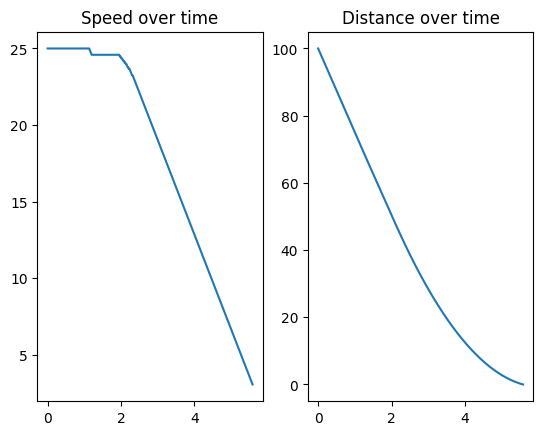

In [30]:
history, final_state = simulate_movement(
    speed_in=25,
    distance_in=100,
    road_state_in=0.63,
    polling_rate=60,
    verbose=False
)

print(final_state)
plot_history(history)